# Image Classfication

In this notebook well perform image classification using a convlutional neural network. We'll be using the CIFAR-10 dataset which contains 60000 32x32 colour images of 10 classes, with 6000 images per a class.  Download the dataset from here [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) and unzip it. Even though keras already has the dataset built in let go through the process reading and reshaping the images so you know how.

# Data Prep

First we need to get the images into a format that we can feed into our neural network. We want the images in a numpy matrix where each row represents a picture.


In [1]:
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

The images have been saved in a format for python called [pickle](https://pythontips.com/2013/08/02/what-is-pickle-in-python/). This allows us to read each image easily into numpy arrays. The images have been split into 6 batches, each batch contains 10,000 images.

In [2]:
imgs_dir = "/home/dom/datasets/cifar-10-pickle/" #change this to the correct path for you

In [3]:
with open(os.path.join(imgs_dir ,'data_batch_1'), 'rb') as f: #rb for read binary
    data= pickle.load(f, encoding='bytes')
data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

The dataset is labeled 0-9, each number corresponds to which class the image belongs

In [4]:
labels = data[b'labels']
labels[:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

Since the images have been flattend into a vector of pixels well have to reshape them before we can view them.

In [5]:
imgs = data[b'data']
imgs.shape # 10000 * (32 * 32 * 3)

(10000, 3072)

First we'll reshape and then transpose the dimensions, after that we can plot the image to see a rather pixalted lorry. For the purpose of practice it's simpler to work with lower quality images, since well be able to train our models quickers, however the same code can be adapted for bigger images.

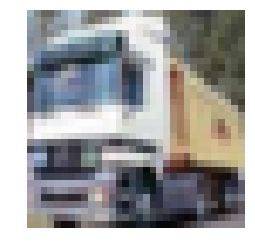

In [6]:
single_img =  np.reshape(imgs[1],(3,32,32)).transpose([1,2,0])
plt.axis('off')
plt.imshow(single_img)

We can reshape all of the images using numpy

In [7]:
imgs = imgs.reshape(10000,3,32,32)
imgs = imgs.transpose([0,2,3,1])
imgs.shape

(10000, 32, 32, 3)

Lets plot the first occurence of each class as a sanity check.

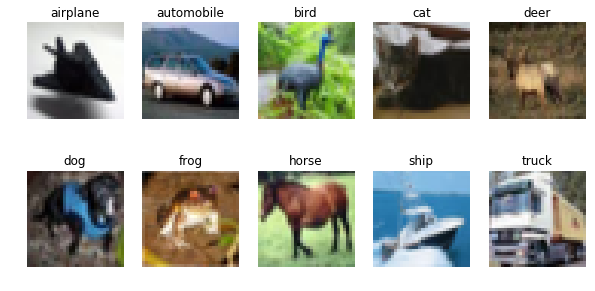

In [8]:
ten_imgs = imgs[[labels.index(i) for i in range(10)]]

fig, ax_arr = plt.subplots(2,5)
img_lables = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
iterable = zip(ten_imgs,ax_arr.flatten(),img_lables)
for img, ax,label in iterable:
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_title(label)

fig.set_size_inches(10,5)

## Convert to grayscale

Since we don't want to work with 3 dimensions we can convert the image to gray scale by taking the average pixel value for across all 3 colour channels. Note the model that we'll be using can work with color images  but we'll get quick training times working with gray scale.

Text(0.5,1,'Dog')

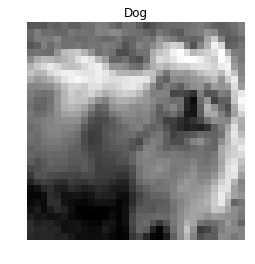

In [9]:
grey_imgs = np.mean(imgs,axis=3,keepdims=True)
plt.imshow(np.squeeze(grey_imgs[40]),cmap="gray")
plt.axis("off");
plt.title("Dog")

Lets put all those above steps together in one function.  

In [10]:
def read_imgs(path,to_gray = True):
    
    with open(path, 'rb') as f:
        data= pickle.load(f, encoding='bytes')
   
    labels = data[b'labels']
    labels = np.array(labels)
    imgs = data[b'data']
    imgs = imgs.astype("float32")
    
    imgs = imgs.reshape(imgs.shape[0],3,32,32)
    imgs = imgs.transpose([0,2,3,1])
    if to_gray:
        imgs = np.mean(imgs,axis=3,keepdims=True)
        
    return imgs,labels


## Reading Images

Since each batch of images is fairly small, only around 30 Mb we can just read them all into memory at once. If the images where large we might have to be a little smarter about it and use a generator function to only read in the images when needed.


In [11]:
#read in data
n_batches = 1 #only use one batch 
data = [ read_imgs(os.path.join(imgs_dir,f"data_batch_{i}")) for i in range(1,n_batches+1) ]
imgs = np.vstack([ data[i][0] for i in range(n_batches)])
labels = np.hstack([ data[i][1] for i in range(n_batches)])
#create train and test sets
x_train,y_train = imgs,labels
x_test, y_test = read_imgs(os.path.join(imgs_dir,"test_batch"))

## Image normalization

Normalization will help our neural network perform better and train faster. From each image we need to subtract the mean and divide by the standard deviation

$$ x_{norm} = \frac{x - \mu}{\sigma} $$

In [12]:
mean_img = np.mean(grey_imgs,axis=0)
std_img = np.std(grey_imgs,axis=0)
grey_imgs = (grey_imgs - mean_img) / std_img
grey_imgs = grey_imgs.astype("float32")

## Onehot Encoding

Since this is a classifcation problem we need our labels to be onehot encoded.

In [13]:
from keras.utils import to_categorical

/home/dom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
#Onehot encode
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [15]:
y_train.shape

(10000, 10)

# Network Architechture

The rough overiew of our  network structure is shown bellow.

![](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-07-at-7.26.20-AM.png)


Essentialy we apply convolution then pooling and repeat. At the end we have a fully connected layers which we'll apply softmax to do classification, allowing us to output a vector of probabilities. In our model however well have 4 convlutional layers and we'll also add some dropout layers which helps the model generalise better and reduces overfitting.


In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

#depending on GPU memory may need to lower batch size
batch_size = 512
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 1)

In [17]:
input_shape

(32, 32, 1)

In [18]:
model = Sequential()
#we can be ecplicit about the parameters we pass
model.add(Conv2D(filters=32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#or we can use the sort from
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [19]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


In [ ]:
#will take a long time without a GPU
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

If we trained the model for longer and on the 3D images we could get up to around 80% accuracy.

# Saving and Loading models

After training we'll want to save the model

In [22]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model


We can load it back into memory and use it to make predictions.

In [23]:
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

preds  = model.predict(x_test[:10])
np.argmax(preds,axis=0)

array([1, 1, 8, 4, 0, 0, 5, 0, 3, 1])

# Tensorflow

Below is the same model but implemented using tensorflow.

In [24]:
import tensorflow as tf

We a using a  variable_scope with `tf.AUTO_REUSE` this allows us to
create variables if they do not exist, and reuse them otherwise, this makes working inside a jupyter notebook easier, since we can run the cell multiple times without it causing an error.

In [25]:
with tf.variable_scope('convnet', reuse=tf.AUTO_REUSE):    
    
    learning_rate = 0.001
    dropout_rate = tf.placeholder("float32",name="dropout_rate")
    X = tf.placeholder("float32",shape=(None,32,32,1) )
    Y = tf.placeholder("int64",shape=(None))
    
    # Convolution Layer with 32 filters and a kernel size of 5
    conv1 = tf.layers.conv2d(X, 32, 5, activation=tf.nn.relu)
    # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
    conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

    # Convolution Layer with 64 filters and a kernel size of 3
    conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
    # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
    
    # Flatten the data to a 1-D vector for the fully connected layer
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.contrib.layers.fully_connected(fc1, 1024)
     # Apply Dropout=
    fc1 = tf.layers.dropout(fc1, rate=dropout_rate, training=True)

    # Logits Layer with 10 classes
    logits = tf.contrib.layers.fully_connected(fc1,10)
    
    #Predictions
    pred_classes = tf.argmax(logits,axis=1)
    pred_probs = tf.nn.softmax(logits)

    correct_pred = tf.equal(pred_classes, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=tf.cast(Y, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    


The batch [generator](https://stackoverflow.com/questions/1756096/understanding-generators-in-python) bellow will allow us to easily feed data into our model. 

In [26]:
def batch_generator(x,y,batch_size):
    
    n = x.shape[0]
    i1,i2 = 0,batch_size
    
    while True:
        if i2 > n:
            i1,i2 = 0,batch_size
        output = x[i1:i2],y[i1:i2]
        i1,i2 = i1+batch_size, i2+batch_size
        yield output


In [29]:
nepochs = 10000
display_step = 1000
batch = batch_generator(x_train,labels,128)
error_rate = []

Now that we've create our graph and a function to feed in the data we can train the model

In [30]:
sess = tf.Session()   
sess.run(tf.global_variables_initializer())
    
for step in range(nepochs):
    #Get next batch of data for model
    batch_x, batch_y = next(batch)
    #Train model
    feed_dict = {X:batch_x,Y:batch_y,dropout_rate:0.2}
    sess.run(train_op,feed_dict)
    if step % display_step == 0:            
        
        #Check model accuracy
        feed_dict={X: batch_x,Y: batch_y,dropout_rate: 0.0}
        loss, acc = sess.run([loss_op, accuracy], feed_dict)
        error_rate.append(acc)
                
        print("Step " + str(step) + ",  Loss = " + \
              "{:.4f}".format(loss) + ", Accuracy = " + \
                "{:.3f}".format(acc))

Step 0,  Loss = 47.5065, Accuracy = 0.156
Step 1000,  Loss = 2.3026, Accuracy = 0.109
Step 2000,  Loss = 2.3026, Accuracy = 0.070
Step 3000,  Loss = 2.3026, Accuracy = 0.102
Step 4000,  Loss = 2.3026, Accuracy = 0.078
Step 5000,  Loss = 2.3026, Accuracy = 0.078
Step 6000,  Loss = 2.3026, Accuracy = 0.109
Step 7000,  Loss = 2.3026, Accuracy = 0.156
Step 8000,  Loss = 2.3026, Accuracy = 0.125
Step 9000,  Loss = 2.3026, Accuracy = 0.133
